In [8]:
import os
import numpy as np
import pandas as pd
import math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import pylab as pl
from sklearn import preprocessing
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
battery = pd.read_csv("data_for_classify.csv")
battery_gps_df = pd.read_csv("battery_gps.csv")

In [3]:
battery = battery.set_index('user_id')
del battery.index.name

battery_gps_df.record_time = battery_gps_df.record_time.astype('datetime64[ns]')

In [4]:
battery_gps_df.head()

,record_time,user_id,level,plugged,accu,lat,lon,grid_x,grid_y,center_lon,center_lat,is_home
0,2017-02-06 23:00:24.622,514,15,0,65.0,52.1205,-106.679,60,67,-106.678986,52.120317,0
1,2017-02-06 23:06:35.928,514,14,0,35.0,52.1211,-106.679,60,68,-106.679020,52.121216,1
2,2017-02-06 23:16:18.378,514,14,0,11.0,52.1208,-106.678,61,68,-106.677560,52.121237,0
3,2017-02-06 23:21:19.717,514,14,0,22.0,52.1208,-106.678,61,68,-106.677560,52.121237,0
4,2017-02-06 23:30:26.527,514,14,0,67.0,52.1209,-106.678,61,68,-106.677560,52.121237,0


In [5]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(battery.values)

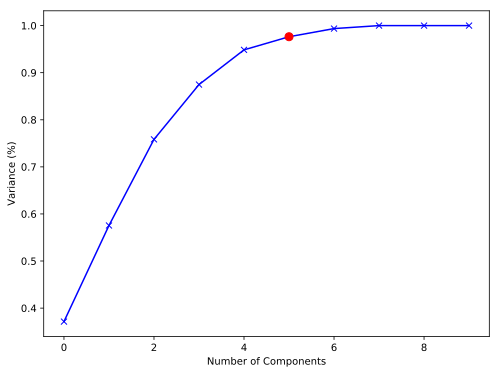

In [6]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(8,6))
xy = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xy,  'bx-')
plt.plot(5, xy[5], 'ro', markersize=8)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.savefig("./imgs/choosing_num_of_components.pdf", bbox_inches='tight')
plt.show()

In [13]:
X = data_rescaled
n_samples = X.shape[0]
X_transformed = pca.fit_transform(X)

# We center the data and compute the sample covariance matrix.
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):
    #print('eigenvectors')
    print(eigenvector.T)
    #print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    #print('eigenvalues')
    print(eigenvalue)

[-0.37066287  0.47966059 -0.45972714  0.01994741 -0.209796   -0.2648054
 -0.00083291  0.29548765  0.05537789 -0.46504966]
0.19800604710468633
[ 0.02973329 -0.12032895 -0.0414999   0.20088128  0.70745584 -0.46973413
  0.0322533  -0.1728219   0.38016305 -0.21444297]
0.10881422550152971
[-0.29670595 -0.22379141  0.191165    0.02131613  0.21617585 -0.14863789
  0.59442187  0.41318856 -0.48157974  0.00883962]
0.0975060174639574
[-0.78685889 -0.11865437  0.02876774  0.10659599 -0.13602389  0.07516049
  0.12009725 -0.42243968  0.26241213  0.26209461]
0.06205133806321471
[-0.06758878 -0.31736969 -0.27757536  0.75053527  0.0518716   0.29539996
 -0.30784711  0.19183623 -0.17215457 -0.0565419 ]
0.03931859967338645
[ 0.34065271  0.21095063 -0.41383039  0.28662355 -0.07225356  0.15315132
  0.67946998 -0.22717097  0.10788094  0.18012944]
0.014854840094968732
[ 0.08481866  0.00352779 -0.13705969  0.17564084 -0.24209394 -0.71291639
 -0.1845521  -0.104652   -0.29770684  0.49260345]
0.009212299105329088

### $n\_components = 5$ would be a good choice

In [7]:
# pca to reduce feature dimensions
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(data_rescaled)

columns = ['pca_%i' % i for i in range(n_components)]
battery_pca = pd.DataFrame(pca.transform(battery), columns=columns, index=battery.index)

In [8]:
battery_pca.head()

,pca_0,pca_1,pca_2,pca_3,pca_4
514,-24.347922,46.900867,33.192416,-5.304239,2.021907
534,-25.479444,62.244267,26.193745,-10.674571,6.798416
551,-24.744195,16.904881,14.475450,-1.984055,12.050656
555,-19.720974,26.325310,17.359712,-3.137214,6.666786
559,-22.763293,-2.771319,-0.438217,-0.270113,18.289174


In [77]:
battery_pca.to_csv('battery_pca.csv', index=False)

In [9]:
mat = battery_pca.values

In [10]:
SSE = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(mat)
    SSE.append(km.inertia_)

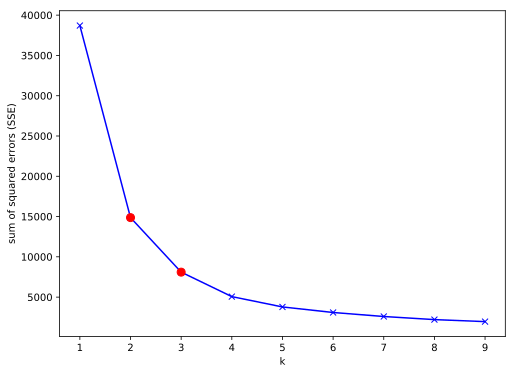

In [11]:
plt.figure(figsize=(8,6))
plt.plot(K, SSE, 'bx-')
plt.plot(K[1], SSE[1], 'ro', markersize=8)
plt.plot(K[2], SSE[2], 'ro', markersize=8)
plt.xlabel('k')
plt.ylabel('sum of squared errors (SSE)')
plt.savefig("./imgs/elbow_method_for_optimal_k.pdf", bbox_inches='tight')
plt.show()

#### According to elbow method, we know that the optimal $k$ is 2 （or 3，need to be discussed）. 

In [12]:
km_2 = KMeans(n_clusters=2)

In [13]:
km_2.fit(mat)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
labels_2 = km_2.labels_

In [15]:
labels_2

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
      dtype=int32)

In [16]:
silhouette_avg = silhouette_score(battery.values, labels_2)
print("For n_clusters =", 2, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.4353026914920364


In [17]:
sample_silhouette_values = silhouette_samples(battery.values, labels_2)

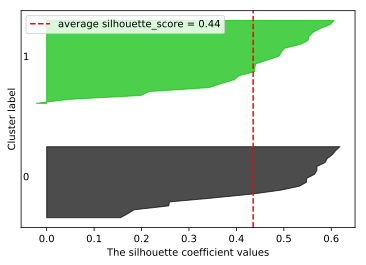

In [18]:
fig,ax = plt.subplots(1)

y_lower = 10
for i in range(2):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels_2 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 2)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticklabels([])
ax.set_yticks([])

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.legend(['average silhouette_score = 0.44'])
plt.savefig('./imgs/silhouette_2_clusters.pdf', bbox_inches='tight')
plt.show()

In [19]:
km_3 = KMeans(n_clusters=3)

In [20]:
km_3.fit(mat)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
labels_3 = km_3.labels_

In [22]:
labels_3

array([2, 1, 0, 2, 0, 1, 2, 1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 2, 0, 2, 2, 1,
       2, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2],
      dtype=int32)

In [23]:
silhouette_avg = silhouette_score(battery.values, labels_3)
print("For n_clusters =", 3, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.38031600248226766


In [24]:
sample_silhouette_values = silhouette_samples(battery.values, labels_3)

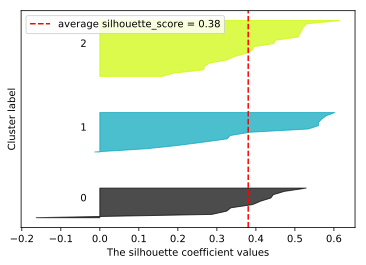

In [25]:
fig,ax = plt.subplots(1)

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels_3 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticklabels([])
ax.set_yticks([])

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.legend(['average silhouette_score = 0.38'])
plt.savefig('./imgs/silhouette_3_clusters.pdf', bbox_inches='tight')
plt.show()

In [26]:
results = pd.DataFrame([battery_pca.index, labels_2, labels_3]).T

In [27]:
results.columns = ['user_id', 'label_for_2_clusters', 'label_for_3_clusters']

In [28]:
results.head()

,user_id,label_for_2_clusters,label_for_3_clusters
0,514,0,2
1,534,0,1
2,551,1,0
3,555,1,2
4,559,1,0


In [47]:
results.to_csv('kmeans-results.csv', index=False)

In [29]:
battery.reset_index(inplace=True)

In [30]:
battery.rename(columns={'index':'user_id'}, inplace=True)

In [31]:
battery.head()

,user_id,home_charge_perc,uncharge_perc,charging_mode1_perc,charging_mode2_perc,charge_count,charge_length,charge_cell_counts,battery_level_bin_0_perc,battery_level_bin_1_perc,battery_level_bin_2_perc
0,514,0.681629,0.642100,0.356244,0.001656,83,27.048193,33,0.380755,0.411891,0.207353
1,534,0.644766,0.671904,0.168615,0.159481,100,18.772277,13,0.484289,0.470954,0.044757
2,551,0.899927,0.570759,0.422993,0.006248,56,49.175439,17,0.283037,0.422212,0.294752
3,555,0.456202,0.721056,0.278944,0.000000,57,30.842105,17,0.233027,0.640538,0.126435
4,559,0.970503,0.629722,0.370278,0.000000,35,58.444444,2,0.243688,0.462310,0.294002


In [32]:
battery_results = pd.merge(battery, results, on='user_id', how='outer')

In [33]:
battery_results.head()

,user_id,home_charge_perc,uncharge_perc,charging_mode1_perc,charging_mode2_perc,charge_count,charge_length,charge_cell_counts,battery_level_bin_0_perc,battery_level_bin_1_perc,battery_level_bin_2_perc,label_for_2_clusters,label_for_3_clusters
0,514,0.681629,0.642100,0.356244,0.001656,83,27.048193,33,0.380755,0.411891,0.207353,0,2
1,534,0.644766,0.671904,0.168615,0.159481,100,18.772277,13,0.484289,0.470954,0.044757,0,1
2,551,0.899927,0.570759,0.422993,0.006248,56,49.175439,17,0.283037,0.422212,0.294752,1,0
3,555,0.456202,0.721056,0.278944,0.000000,57,30.842105,17,0.233027,0.640538,0.126435,1,2
4,559,0.970503,0.629722,0.370278,0.000000,35,58.444444,2,0.243688,0.462310,0.294002,1,0


In [34]:
cols = battery_results.columns.tolist()
cols.pop(-1)
cols.pop(-1)
cols.pop(0)

'user_id'

In [35]:
cols

['home_charge_perc',
 'uncharge_perc',
 'charging_mode1_perc',
 'charging_mode2_perc',
 'charge_count',
 'charge_length',
 'charge_cell_counts',
 'battery_level_bin_0_perc',
 'battery_level_bin_1_perc',
 'battery_level_bin_2_perc']

In [36]:
titles = ['Percentage of home charging', 
         'Percentage of time of uncharging', 
         'Percentage of time of charging in mode 1', 
         'Percentage of time of charging in mode 2', 
         'Number of charges', 
         'Average charging length', 
         'Number of grid cells charged in',
         'Percentage of battery level between 0 and 50', 
         'Percentage of battery level between 50 and 100', 
         'Percentage of battery level is 100 and in charging']

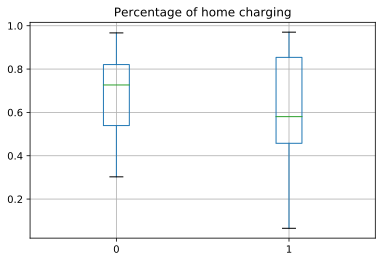

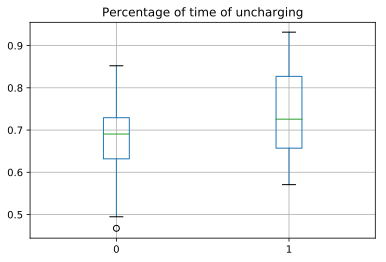

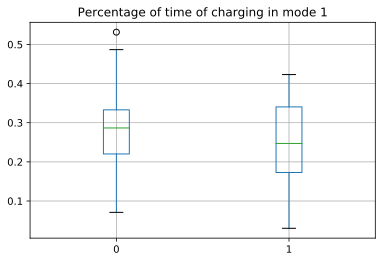

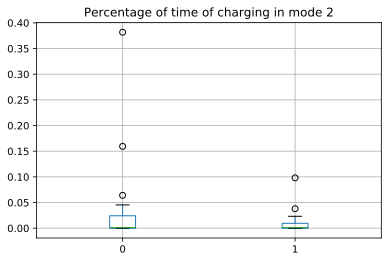

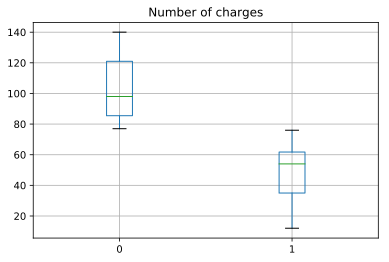

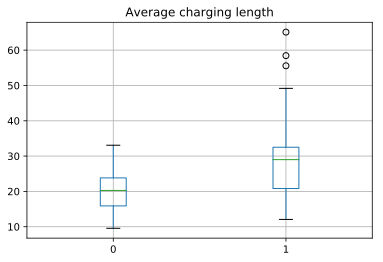

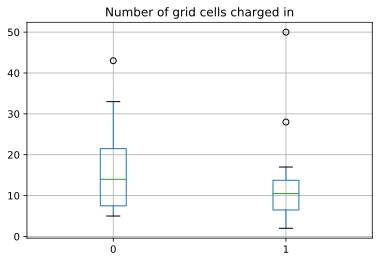

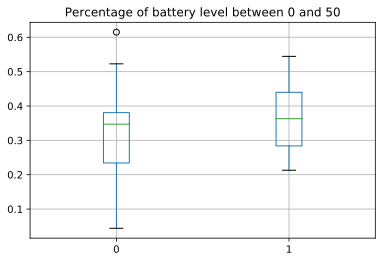

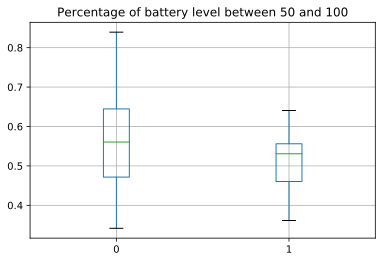

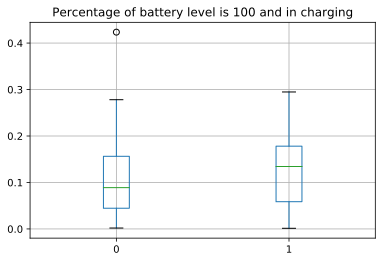

In [37]:
for col in cols:
    battery_results.boxplot(column=col, by='label_for_2_clusters')
    plt.suptitle("")
    plt.title(titles.pop(0))
    plt.xlabel("")
    plt.savefig('./imgs/2_clusters_' + col + '_similarities.pdf', bbox_inches='tight')
    plt.show()

In [38]:
titles = ['Percentage of home charging', 
         'Percentage of time of uncharging', 
         'Percentage of time of charging in mode 1', 
         'Percentage of time of charging in mode 2', 
         'Number of charges', 
         'Average charging length', 
         'Number of grid cells charged in',
         'Percentage of battery level between 0 and 50', 
         'Percentage of battery level between 50 and 100', 
         'Percentage of battery level is 100 and in charging']

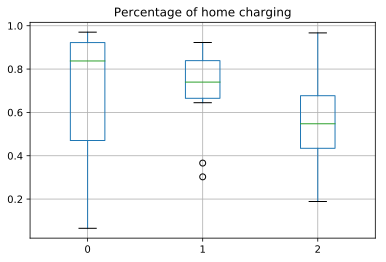

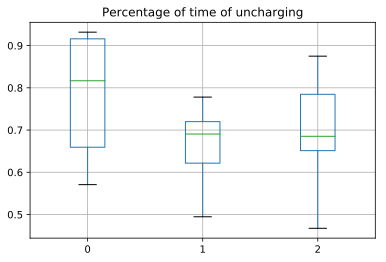

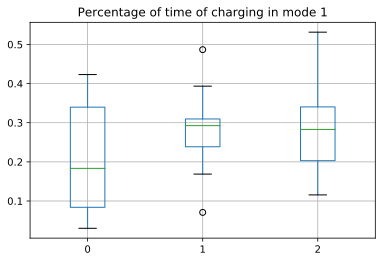

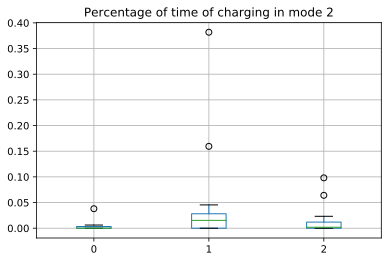

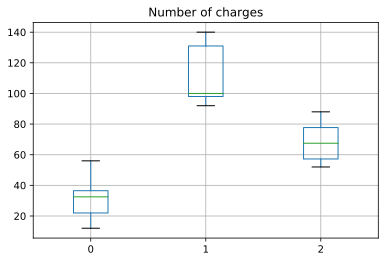

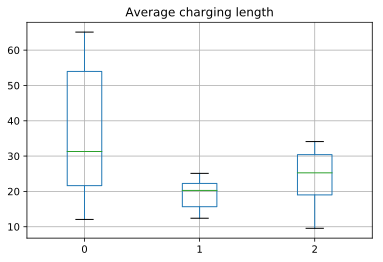

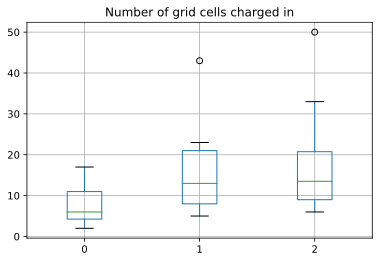

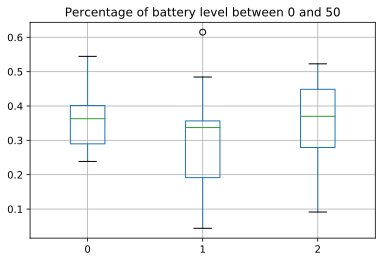

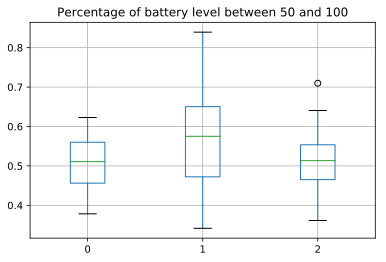

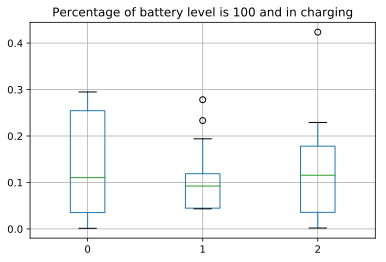

In [39]:
for col in cols:
    battery_results.boxplot(column=col, by='label_for_3_clusters')
    plt.suptitle("")
    plt.title(titles.pop(0))
    plt.xlabel("")
    plt.savefig('./imgs/3_clusters_' + col + '_similarities.pdf', bbox_inches='tight')
    plt.show()

In [40]:
battery_results.groupby(['label_for_2_clusters']).mean()

,user_id,home_charge_perc,uncharge_perc,charging_mode1_perc,charging_mode2_perc,charge_count,charge_length,charge_cell_counts,battery_level_bin_0_perc,battery_level_bin_1_perc,battery_level_bin_2_perc,label_for_3_clusters
label_for_2_clusters,,,,,,,,,,,,
0,1088.105263,0.670187,0.673958,0.287278,0.038764,102.842105,20.159226,16.421053,0.318684,0.565104,0.116212,1.315789
1,1082.136364,0.594296,0.748975,0.240974,0.010052,47.818182,30.736633,12.181818,0.363079,0.507472,0.129448,1.090909


In [41]:
battery_results.groupby(['label_for_2_clusters']).std()

,user_id,home_charge_perc,uncharge_perc,charging_mode1_perc,charging_mode2_perc,charge_count,charge_length,charge_cell_counts,battery_level_bin_0_perc,battery_level_bin_1_perc,battery_level_bin_2_perc,label_for_3_clusters
label_for_2_clusters,,,,,,,,,,,,
0,270.593359,0.209581,0.098338,0.110980,0.091471,21.132553,5.909151,10.329654,0.152082,0.127425,0.107695,0.477567
1,267.872624,0.280695,0.113508,0.114511,0.021804,18.806373,14.291941,10.191670,0.103125,0.077636,0.093791,1.019294


In [42]:
battery_results.groupby(['label_for_2_clusters']).size()

label_for_2_clusters
0    19
1    22
dtype: int64

In [43]:
battery_results.groupby(['label_for_3_clusters']).mean()

,user_id,home_charge_perc,uncharge_perc,charging_mode1_perc,charging_mode2_perc,charge_count,charge_length,charge_cell_counts,battery_level_bin_0_perc,battery_level_bin_1_perc,battery_level_bin_2_perc,label_for_2_clusters
label_for_3_clusters,,,,,,,,,,,,
0,1065.600000,0.65389,0.788347,0.206740,0.004914,30.800000,36.805317,7.700000,0.359485,0.505250,0.135266,1.000000
1,1094.846154,0.71010,0.665069,0.283432,0.051499,112.615385,19.114477,15.384615,0.305861,0.581586,0.112552,0.000000
2,1088.444444,0.55766,0.708516,0.278205,0.013279,68.555556,24.593880,16.833333,0.359539,0.516014,0.124447,0.666667


In [44]:
battery_results.groupby(['label_for_3_clusters']).std()

,user_id,home_charge_perc,uncharge_perc,charging_mode1_perc,charging_mode2_perc,charge_count,charge_length,charge_cell_counts,battery_level_bin_0_perc,battery_level_bin_1_perc,battery_level_bin_2_perc,label_for_2_clusters
label_for_3_clusters,,,,,,,,,,,,
0,302.118520,0.357532,0.139228,0.142860,0.011832,12.425780,18.726072,4.808557,0.097196,0.077941,0.119461,0.000000
1,261.108485,0.185441,0.079108,0.103431,0.108230,18.323657,4.190138,10.103947,0.157293,0.132970,0.077620,0.000000
2,263.501138,0.211092,0.098671,0.098710,0.026170,11.763464,7.168508,11.597414,0.121816,0.091502,0.106161,0.485071


In [45]:
battery_results.groupby(['label_for_3_clusters']).size()

label_for_3_clusters
0    10
1    13
2    18
dtype: int64

In [40]:
# n is the number of clusters, label is the specific label you want to draw,
def result_visualization(results, n = 2, label = 0, num_users = 3):
    users = results[results['label for ' + str(n) + ' clusters'] == label].user_id.values
    
    if num_users > len(users):
        num_users = len(users)
        
    users = np.random.choice(users, num_users)
        
    plt.figure(figsize=(12,4))
        
    for user in users:
        plt.plot(battery_gps_df[battery_gps_df.user_id == user].record_time, battery_gps_df[battery_gps_df.user_id == user].level)
        
    name = str(num_users) + "_users_in_cluster_" + str(label) + "_of_" + str(n) + "_means.pdf"
    filename = os.path.join('./imgs', name)
    plt.savefig(filename, bbox_inches='tight')

/Users/wbb/anaconda3/envs/cmpt826/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


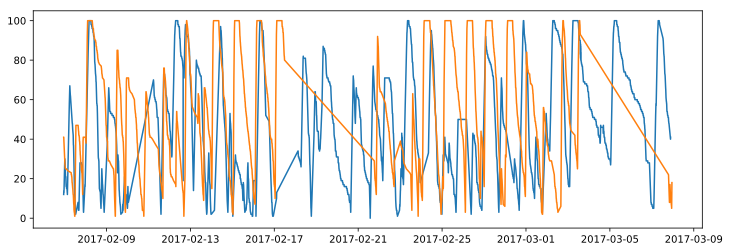

In [41]:
result_visualization(results, n = 2, label = 0, num_users=2)

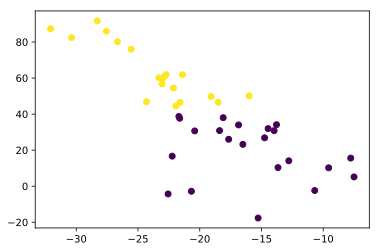

In [42]:
plt.scatter(battery_pca.pca_0, battery_pca.pca_1, c = results['label for 2 clusters'])
plt.savefig('./imgs/2_clusters.pdf', bbox_inches='tight')

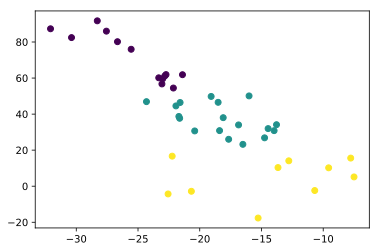

In [43]:
plt.scatter(battery_pca.pca_0, battery_pca.pca_1, c = results['label for 3 clusters'])
plt.savefig('./imgs/3_clusters.pdf', bbox_inches='tight')

In [28]:
results_direct_pca_df = pd.read_csv('results_of_direct_pca.csv')

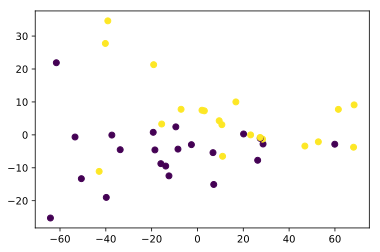

In [29]:
plt.scatter(battery_pca.pca_0, battery_pca.pca_1, c = results_direct_pca_df['label for 2 clusters'])
#plt.savefig('./imgs/3_clusters.pdf', bbox_inches='tight')

In [49]:
q75_df = pd.read_csv('LA_final_clusters_ngrams(1, 2)_quantile75.csv')
q90_df = pd.read_csv('LA_final_clusters_ngrams(1, 2)_quantile90.csv')

In [51]:
q75_df.columns = ['user_id', 'LA_label_for_2_clusters']
q90_df.columns = ['user_id', 'LA_label_for_3_clusters']

In [52]:
LA_df = pd.merge(q75_df, q90_df, on='user_id', how='outer')

In [63]:
# -1 for single nodes in LA
LA_df.loc[LA_df.LA_label_for_2_clusters > 2, 'LA_label_for_2_clusters'] = -1
LA_df.loc[LA_df.LA_label_for_3_clusters > 3, 'LA_label_for_3_clusters'] = -1

In [64]:
LA_df.groupby('LA_label_for_3_clusters').size()

LA_label_for_3_clusters
-1    12
 1    13
 2    10
 3     7
dtype: int64

In [66]:
LA_df = LA_df.drop([11])

In [67]:
LA_df

,user_id,LA_label_for_2_clusters,LA_label_for_3_clusters
0,514,2,2
1,534,1,1
2,551,2,2
3,555,-1,3
4,559,2,2
5,767,1,1
6,793,1,1
7,933,-1,3
8,942,1,1
9,943,2,2


In [68]:
results = pd.merge(results, LA_df, on='user_id', how='outer')

In [70]:
results.groupby(['label_for_2_clusters', 'LA_label_for_2_clusters']).size()

label_for_2_clusters  LA_label_for_2_clusters
0                     -1                          4
                       1                         10
                       2                          5
1                     -1                          3
                       1                          8
                       2                         11
dtype: int64

## So 0 in k-means is 1 in LA and 1 in k-means is 2 in LA 

In [71]:
results.groupby(['label_for_3_clusters', 'LA_label_for_3_clusters']).size()

label_for_3_clusters  LA_label_for_3_clusters
0                     -1                         4
                       1                         2
                       2                         3
                       3                         1
1                     -1                         2
                       1                         6
                       2                         3
                       3                         2
2                     -1                         6
                       1                         5
                       2                         4
                       3                         3
dtype: int64

## So 0 in k-means is 2 in LA and 1 in k-means is 1 in LA and 2 in k-means is 3 in LA

In [78]:
two_clusters_fir = results.loc[(results.label_for_2_clusters == 0) & (results.LA_label_for_2_clusters == 1), 'user_id'].tolist()
two_clusters_sec = results.loc[(results.label_for_2_clusters == 1) & (results.LA_label_for_2_clusters == 2), 'user_id'].tolist()
three_clusters_fir = results.loc[(results.label_for_3_clusters == 0) & (results.LA_label_for_3_clusters == 2), 'user_id'].tolist()
three_clusters_sec = results.loc[(results.label_for_3_clusters == 1) & (results.LA_label_for_3_clusters == 1), 'user_id'].tolist()
three_clusters_thr = results.loc[(results.label_for_3_clusters == 2) & (results.LA_label_for_3_clusters == 3), 'user_id'].tolist()

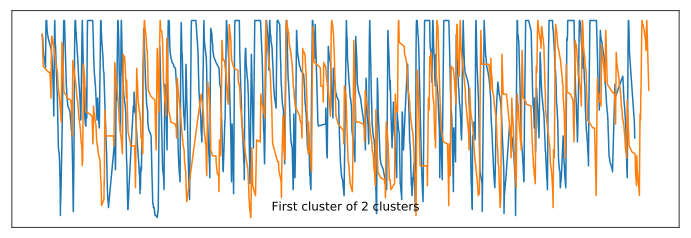

In [100]:
users = np.random.choice(two_clusters_fir, 2, replace=False)
fig, ax = plt.subplots(1, figsize=(12,4))
        
for user in users:
    plt.plot(battery_gps_df[battery_gps_df.user_id == user].record_time, battery_gps_df[battery_gps_df.user_id == user].level)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
plt.title("First cluster of 2 clusters", position=(0.5, 0.05))

#name = str(num_users) + "_users_in_cluster_" + str(label) + "_of_" + str(n) + "_means.pdf"
#filename = os.path.join('./imgs', name)
plt.savefig('./imgs/fir_in_2_clusters.pdf', bbox_inches='tight')

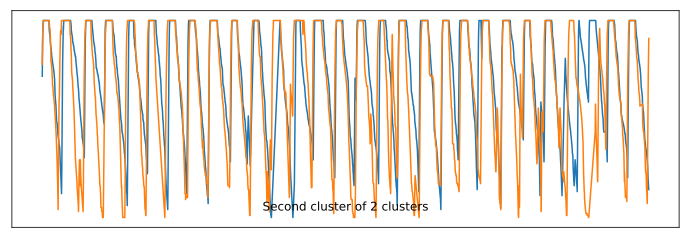

In [101]:
users = np.random.choice(two_clusters_sec, 2, replace=False)
fig, ax = plt.subplots(1, figsize=(12,4))
        
for user in users:
    plt.plot(battery_gps_df[battery_gps_df.user_id == user].record_time, battery_gps_df[battery_gps_df.user_id == user].level)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
plt.title("Second cluster of 2 clusters", position=(0.5, 0.05))

#name = str(num_users) + "_users_in_cluster_" + str(label) + "_of_" + str(n) + "_means.pdf"
#filename = os.path.join('./imgs', name)
plt.savefig('./imgs/sec_in_2_clusters.pdf', bbox_inches='tight')

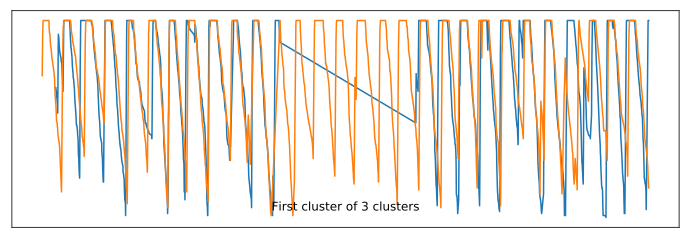

In [102]:
users = np.random.choice(three_clusters_fir, 2, replace=False)
fig, ax = plt.subplots(1, figsize=(12,4))
        
for user in users:
    plt.plot(battery_gps_df[battery_gps_df.user_id == user].record_time, battery_gps_df[battery_gps_df.user_id == user].level)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
plt.title("First cluster of 3 clusters", position=(0.5, 0.05))

#name = str(num_users) + "_users_in_cluster_" + str(label) + "_of_" + str(n) + "_means.pdf"
#filename = os.path.join('./imgs', name)
plt.savefig('./imgs/fir_in_3_clusters.pdf', bbox_inches='tight')

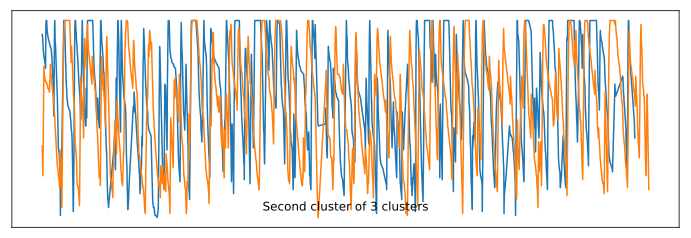

In [103]:
users = np.random.choice(three_clusters_sec, 2, replace=False)
fig, ax = plt.subplots(1, figsize=(12,4))
        
for user in users:
    plt.plot(battery_gps_df[battery_gps_df.user_id == user].record_time, battery_gps_df[battery_gps_df.user_id == user].level)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
plt.title("Second cluster of 3 clusters", position=(0.5, 0.05))

#name = str(num_users) + "_users_in_cluster_" + str(label) + "_of_" + str(n) + "_means.pdf"
#filename = os.path.join('./imgs', name)
plt.savefig('./imgs/sec_in_3_clusters.pdf', bbox_inches='tight')

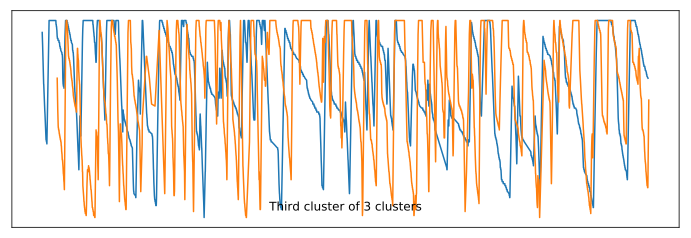

In [104]:
users = np.random.choice(three_clusters_thr, 2, replace=False)
fig, ax = plt.subplots(1, figsize=(12,4))
        
for user in users:
    plt.plot(battery_gps_df[battery_gps_df.user_id == user].record_time, battery_gps_df[battery_gps_df.user_id == user].level)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
plt.title("Third cluster of 3 clusters", position=(0.5, 0.05))

#name = str(num_users) + "_users_in_cluster_" + str(label) + "_of_" + str(n) + "_means.pdf"
#filename = os.path.join('./imgs', name)
plt.savefig('./imgs/thr_in_3_clusters.pdf', bbox_inches='tight')